# Population demographics for climate science: lifetime exposure

Based on demographic data from UNWPP life expectancy, Wittgenseit capital data explorer cohort size, ISIMIP gridded population data & shapefiles of country borders from natural earth + a climate event exposure dataset, compute lifetime exposure at (a) country average level (b) gridscale level 

From Grant et al. 2023

rosa.pietroiusti@vub.be 


# PART 1. Country-level 

## Description:
Calculate country-level lifetime exposure for different birth cohorts. From exposure.py and emergence.py (Grant et al 2023)

## Functions included / modifications made:
- removed GMT remapping. Propose to make this a separate clearly named function that you apply wherever you want to to reindex the climate dataset. 
- removed everything related to PIC
- outputting dfs for single runs/simulations instead of dictionaries with each simulation as an entry in the dictionary (i.e. make an external loop with the simulations) 
- **calc_weighted_fldmean, calc_life_exposure and calc_lifetime exposure**: These functions calculate the avereage lifetime exposure of an average individual of a certain age in a certain country. They take the population-weighted average of exposure over the country (weighted fieldmean) per year, and then they accumulate this over the lifetime of an individual in each agegroup in that country. i.e. they give you the experience of e.g. an "average" 5-year old in Belgium (correct?) 
    - I have the functions only output a dataframe (df_le) where rows are year of birth, columns are countries, and values are average accumulated number of events over lifetime of someone born in that year. 
- **calc_cohort_lifetime_exposure**: Renamed to **calc_cohort_exposure_per_year**, as this is what it is doing. Calculates the population-weighted average number of events occurringbin each country each year, and multiplies this by the total number of people in each age group each year. i.e. tells you each year how many people of each age group are experiencing an event (output da_exposure_cohorts)
    - removed GMT remapping
- **calc_birthyear_align**: tracks diagonally the cohort size each year (i.e. those 0 year old in 1960, 1 year old in 1961 etc...), i.e. tracks how big the "1960 cohort" is every year in the country, based on the da_cohort_size. 
    - Does this change because of in/out migration vs death?
- **ds_cohort_align**: calculates different things for each country based on da_cohort_size and output of calc_birthyear_align, i.e. per cohort size each year, at year 0 and cumulative over all of its existence, and weights of this wrt. all other countries 
    - changed order of variables 
- **from strj_emergence**
    - **ds_exposure_align**: removed .where(da>0) in order to compute cumsum also over zero years and NaN - this looks better ! why were you doing where da>0 ??? 
    - only took extracts of this function

## Issues / to do:
- **calc_cohort_lifetime_exposure**: Renamed to **calc_cohort_exposure_per_year**
    - note. also outputes da_exp_py_pa_pc which is just a dimensional expansion of the population-weighted average exposure per year, with an additional "ages" dimension, see whether to export just the pop-weighted average da and then do the dimensional expansion later when you need it. 
- **ds_cohort_align**:  
    - ages is reduntant? 
- **strj_emergence**
    - look better at other parts of this fxn and if needed
- **ds_exposure_align**
    - rename this function and its output ! 
    - address problem of death year > end of simulation

## Functions not included:
Exposure.py: 
- lreg, vectorize_linreg, resample - put these in utils
- calc_exposure_trends: calculates per gridscale trend in occurrence of extremes in da_AFA and then mean per country
- get_countries_of_region 
- calc-exposure_mmm_xr
- calc_exposure_mmm_pic_xr
- calc_exposure_trends
- calc_lifetime_exposure_pic

Emergence.py: 
- exposure_pic_masking
- calc_unprec_exposure - this is used in strj_emergence, understand better
- pop_frac_stats - also used in strj_emergence
- calc_exposure_emergence
- strj_emergence: only extracted a small part of this function


# PART 2. Gridscale-level

## Description 

Calculate gridscale exposure, from gridscale.py (Grant et al 2023). Everything relating to GMT mapping and PIC was removed, see Luke's original code for these. 

## To do:
- include gridscale_emergence: break it up into different functions

## Don't include (?):
- get_gridscale_union
- collect_global_emergence


In [1]:
#openpyxl, regionmask, netcdf4-py

import xarray as xr
import pickle as pk
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import mapclassify as mc
from copy import deepcopy as cp
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy import stats as sts
import os, glob
import regionmask as rm
#import cartopy.crs as ccrs
#import cartopy as cr
import geopandas as gpd
#import seaborn as sns
import netCDF4


%matplotlib inline 

/apps/brussel/CO7/broadwell/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Init, load climate data

In [2]:
# initialise age and associated time period of interest

ages = np.arange(60,-1,-1)
age_young = 0
age_ref = np.nanmax(ages)
age_range = np.arange(0,105)
year_ref = 2020
year_start = year_ref - age_ref
birth_years = np.arange(year_start,year_ref+1)     
year_end = 2113 # based on maximum life expectancy reported in UN WPP
year_range = np.arange(year_start,year_end+1)

flags = {}
#flags['gmt'] = 'original' # see difference with ar6
flags['extr'] = 'heatwavedarea'
#extremes = [flags['extr']]
#flags['run'] = 1
#flags['rm'] = 'no_rm'

In [3]:
# load climate data, just one as example

i=2
with open('./data/pickles/{}/isimip_AFA_{}_{}.pkl'.format(flags['extr'],flags['extr'],str(i)), 'rb') as f:
            da_AFA = pk.load(f)

# PART 1. Country-level

## 0. load population data

In [ ]:
# load and preprocess country-level population data 

# careful to include only functions in this script !!! not constants that will overwrite your stuff ! 
# e.g. year_range

from population_demographics_climate import *
d_countries = preprocess_all_country_population_data()

# unpack country information
df_countries = d_countries['info_pop']
gdf_country_borders = d_countries['borders']
da_population = d_countries['population_map']
df_birthyears = d_countries['birth_years']
df_life_expectancy_5 = d_countries['life_expectancy_5']
da_cohort_size = d_countries['cohort_size']
countries_regions, countries_mask = d_countries['mask'] 


interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero
Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated


## 1. calc_lifetime_exposure

per country lifetime accumulation per birth cohort, based on population-weighted average of exposure data 

In [5]:

def calc_weighted_fldmean(
    da, # data you are averaging
    weights, # weights you are using to average
    countries_mask, # regionmask object of countries
    ind_country, # indices
):
    """
    calculate weighted average of a climate dataset, per country 
    e..g weights could be a population map or an area map, to calculate an area-weighted average or a population weighted average 
    """
    if isinstance(ind_country, list):
        if len(ind_country) > 1:
            # more than one country
            mask = xr.DataArray(
                np.in1d(countries_mask,ind_country).reshape(countries_mask.shape),
                dims=countries_mask.dims,
                coords=countries_mask.coords,
            )
            da_masked = da.where(mask)
        else:
            pass 
    elif len([ind_country]) == 1:
        # one country
        da_masked = da.where(countries_mask == ind_country)
    
    da_weighted_fldmean = da_masked.weighted(weights).mean(dim=("lat", "lon"))
    
    return da_weighted_fldmean


def calc_life_exposure(
    df_exposure, # rows are years, columns are countries, fields are field-average 
    df_life_expectancy, # rows are years, columns are countries 
    col, # what column of the dfs you are doing this on (country name)
):
    """
    integrate exposure over an individual's lifetime 
    """

    # initialise birth years 
    exposure_birthyears_percountry = np.empty(len(df_life_expectancy))

    for i, birth_year in enumerate(df_life_expectancy.index):

        life_expectancy = df_life_expectancy.loc[birth_year,col] 

        # define death year based on life expectancy
        death_year = birth_year + np.floor(life_expectancy)

        # integrate exposure over full years lived
        exposure_birthyears_percountry[i] = df_exposure.loc[birth_year:death_year,col].sum()

        # add exposure during last (partial) year (QUESTION: what is going on here????)
        exposure_birthyears_percountry[i] = exposure_birthyears_percountry[i] + \
            df_exposure.loc[death_year+1,col].sum() * \
                (life_expectancy - np.floor(life_expectancy))

    # a series for each column to somehow group into a dataframe
    exposure_birthyears_percountry = pd.Series(
        exposure_birthyears_percountry, # accumulated exposure over lifetime 
        index=df_life_expectancy.index, # year of birth 
        name=col, # country name 
    )

    return exposure_birthyears_percountry

#%% ----------------------------------------------------------------
# main function n. 1 (rename calc_avg_lifetime_exposure)
def calc_lifetime_exposure(
    da_AFA, 
    df_countries, 
    countries_regions, # can we delete this ??
    countries_mask, 
    da_population, 
    df_life_expectancy_5, 
):
    """
    Convert yearly climate exposure data (e.g. Area Fraction Affected (AFA)) to average per-country number of extremes affecting one individual across life span. 
    First calculates population-weighted average per country of AFA, then accumulates this over lifetime of individual in that country of each age group 
    i.e. assumes equal population distribution throughout the country (not gridscale).
    Note, this version does not do GMT-remapping. 
    
    Inputs
        da_AFA (da): climate data, annual
        df_countries (df): dataframe with country names 
        countries_regions, # why do we need this ? I think delete and use df_countries.columns instead???
        countries_mask (regionmask object): to mask the climate data
        da_population (da): da of population to do a population-weighted average
        df_life_expectancy_5 (df): life expectancy at birth, rows are year of birth, columns are countries 
    
    Returns
        df_le (df): accumulated lifetime exposure (sum of da_AFA during lifetime), rows are birth years, columns are countries, 
                    average for country (units: number of events)
    
    """
    # initialise dicts
    d_exposure_peryear_percountry = {}

    # get spatial average per country
    for j, country in enumerate(df_countries['name']):

        print('processing country '+str(j+1)+' of '+str(len(df_countries)), end='\r')

        # calculate mean per country weighted by population
        ind_country = countries_regions.map_keys(country)

        # historical + RCP simulations - average over the country, per year, weighted by where the population lives??
        d_exposure_peryear_percountry[country] = calc_weighted_fldmean( 
            da_AFA, # da, area affected 
            da_population, # weights (isimip gridded population array) 
            countries_mask, # mask (regionmask object)
            ind_country, # ind_country (index) - dont think we need this ? 
        )

    # convert dict to dataframe for vectorizing and integrate exposures       
    frame = {k:v.values for k,v in d_exposure_peryear_percountry.items()}
    df_exposure = pd.DataFrame(frame,index=d_exposure_peryear_percountry[country].time.values)  # ISSUE prev: year_range, but then this is defined somewhere else          

    df_le = df_exposure.apply(
        lambda col: calc_life_exposure(
            df_exposure, # reindex here if you want to do GMT remapping 
            df_life_expectancy_5,
            col.name,
        ),
        axis=0,
    )

    return df_le

In [6]:
df_le = calc_lifetime_exposure(
    da_AFA, 
    df_countries, 
    countries_regions, # can we delete this ??
    countries_mask, 
    da_population, 
    df_life_expectancy_5, 
)

In [7]:
df_le

# per country lifetime accumulation per birth cohort, based on population-weighted average of exposure data 

,Aruba,Afghanistan,Angola,Albania,United Arab Emirates,Argentina,Armenia,Antigua and Barbuda,Australia,Austria,...,Saint Vincent and the Grenadines,Venezuela,United States Virgin Islands,Vietnam,Vanuatu,Samoa,Yemen,South Africa,Zambia,Zimbabwe
1960,NaN,3.629712,0.927411,4.249811,11.573129,2.964317,3.281807,NaN,2.313518,1.009919,...,10.785660,10.417482,24.996844,2.705016,26.385676,16.687896,1.554605,0.557694,3.726092,2.652056
1961,NaN,4.110428,0.937526,4.368152,11.758061,3.058422,3.298853,NaN,2.325290,1.024517,...,11.000000,10.496270,25.181005,2.705114,27.712380,17.836321,1.648605,0.598294,3.794848,2.981967
1962,NaN,4.323537,0.810920,4.368152,12.129377,3.068414,3.807211,NaN,2.376619,1.056825,...,10.000000,10.365767,26.365166,2.715951,29.039083,18.984745,2.382162,0.606473,3.775089,3.257122
1963,NaN,4.815828,0.852139,4.668772,12.784970,3.112575,4.055722,NaN,2.431554,1.056825,...,10.971298,11.117225,27.565244,2.675678,30.355176,20.144702,2.589970,0.629664,4.012681,3.376421
1964,NaN,4.825528,0.970819,5.350326,13.728047,3.140601,4.165687,NaN,2.432626,1.056825,...,12.042263,11.656268,28.765323,2.675056,31.449976,21.000000,2.680051,0.649943,4.023565,4.180296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,NaN,26.454825,8.020653,19.967718,58.892435,12.710674,22.278660,NaN,8.476448,8.753452,...,59.750389,38.800033,80.742389,6.234895,75.594646,70.894440,29.579416,5.732685,28.213467,14.229115
2017,NaN,26.702045,8.657173,20.578295,59.723982,13.047788,22.956379,NaN,8.703252,9.001609,...,60.804572,39.651641,81.909263,6.264781,75.720723,71.039229,30.059738,6.034317,28.335173,14.378080
2018,NaN,26.789077,8.934117,21.188872,59.816914,13.279253,23.377323,NaN,8.929539,9.249766,...,61.858755,40.583580,83.076137,6.297442,76.433623,71.184018,30.939294,6.342441,29.247945,15.350677
2019,NaN,27.365536,9.431507,21.799450,60.909837,13.620523,23.793116,NaN,9.138134,9.497922,...,62.912938,41.033253,84.243012,6.330103,76.559701,71.328807,31.747010,6.379947,29.907529,15.447087


Text(0.5, 1.0, 'number of events experienced on average during lifetime \nby each age group (Belgium)')

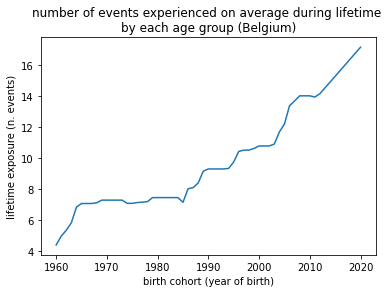

In [8]:
df_le['Belgium'].plot()
plt.xlabel('birth cohort (year of birth)')
plt.ylabel('lifetime exposure (n. events)')
plt.title('number of events experienced on average during lifetime \nby each age group (Belgium)')

In [9]:
df_le['Belgium']

1960     4.395090
1961     4.959321
1962     5.342639
1963     5.829728
1964     6.836479
          ...    
2016    15.651263
2017    16.025650
2018    16.400034
2019    16.774422
2020    17.148807
Name: Belgium, Length: 61, dtype: float64

## 2. calc_cohort_exposure_per_year

In [10]:
def calc_cohort_exposure_peryear( # original name: calc_cohort_lifetime_exposure # or call it: calc_exposure_peryear_percohort
    da_AFA,
    df_countries,
    countries_regions, # delete?
    countries_mask,
    da_population,
    da_cohort_size
                                 ):  
    """
    Multiplies population-weighted avereage annual exposure by cohort size each year in each country. i.e. computes 
    every year how many people of each age group have experienced an event, on average (in unit 000's of people of people)
    
    original name: calc_cohort_lifetime_exposure - but no lifetime accumulation is happening here ! its just multiplication 
    
    Inputs
        da_AFA (da): climate data, annual occurence data 
        df_countries (df): dataframe with country names 
        countries_regions, # why do we need this ? I think delete and use df_countries.columns instead???
        countries_mask (regionmask object): to mask the climate data
        da_population (da): da of population to do a population-weighted average
        df_life_expectancy_5 (df): life expectancy at birth, rows are year of birth, columns are countries 
    
    Returns
        da_exposure_cohort (da):  per age cohort, per country number of people experiencing events each year (unit: 000's people)
        da_exposure_peryear_perage_percountry 
    
    """
    # initialise dicts
    d_exposure_peryear_percountry = {}

    # get spatial average per country per year, weighted by population that year
    for j, country in enumerate(df_countries['name']):
        print('processing country '+str(j+1)+' of '+str(len(df_countries)), end='\r')

        # calculate mean per country weighted by population
        ind_country = countries_regions.map_keys(country)
        d_exposure_peryear_percountry[country] = calc_weighted_fldmean( 
            da_AFA,
            da_population, 
            countries_mask, 
            ind_country, 
        )
    # convert dictionary to data array
    da_exposure_peryear_percountry = xr.DataArray(
        list(d_exposure_peryear_percountry.values()),
        coords={
            'country': ('country', list(d_exposure_peryear_percountry.keys())),
            'time': ('time', da_AFA.time.values),
        },
        dims=[
            'country',
            'time',
        ],
    )
    
    # note. apply GMT mapping here if doing ! 
    
    # multiply average exposure each year by cohort size of each age each year 
    da_exposure_cohort = da_exposure_peryear_percountry * da_cohort_size 
    
    # note. luke was making da_exposure_peryear_perage_percountry_strj (the same as da_exposure_cohort but with gmt mapping), 
    # and da_exposure_peryear_perage_percountry_strj which was just a dimensional expansion of d_exposure_peryear_percountry
    # to have the _perage column (but was multiplied by xr.full_like(da_cohort_size,1)
    da_exposure_peryear_perage_percountry = da_exposure_peryear_percountry * xr.full_like(da_cohort_size,1) # a dimensional expansion!! 
    # could also just export da_exposure_peryear_percountry and do this dimensional expansion later wherever it is that you need it ! 
    
    return da_exposure_cohort, da_exposure_peryear_perage_percountry

In [11]:
da_exposure_cohort, da_exposure_peryear_perage_percountry = calc_cohort_exposure_peryear( # original name: calc_cohort_lifetime_exposure
    da_AFA,
    df_countries,
    countries_regions, # delete?
    countries_mask,
    da_population,
    da_cohort_size   )

Text(0, 0.5, 'events*people (1k)')

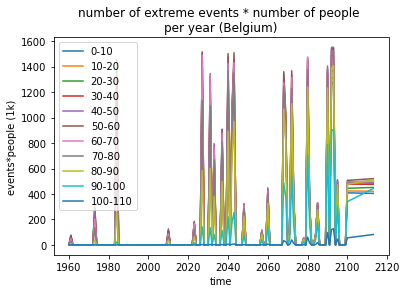

In [12]:
df = da_exposure_cohort.sel(country='Belgium').to_pandas()
n = 10
df.groupby(np.arange(len(df.columns)) // n, axis=1).sum().plot() # group every 5 years together and calc sum and plot 
# Get the current legend
legend = plt.legend()
# Multiply the legend labels by 5
new_legend_labels = [f'{int(label.get_text()) * n}-{int(label.get_text()) * n + n}' for label in legend.get_texts()]
# Set the modified labels to the legend
for i, label in enumerate(legend.get_texts()):
    label.set_text(new_legend_labels[i])
    
plt.title('number of extreme events * number of people \nper year (Belgium)')
plt.ylabel('events*people (1k)')


Text(0, 0.5, 'n. events')

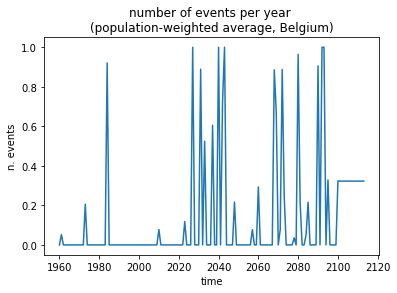

In [13]:
da_exposure_peryear_perage_percountry.sel(country='Belgium', ages=0).plot()
plt.title('number of events per year \n(population-weighted average, Belgium)')
plt.ylabel('n. events')

In [14]:
da_exposure_cohort.sel(country='Belgium').to_pandas()

ages,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
time,,,,,,,,,,,,,,,,,,,,,
1960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1961,8.109069,8.022420,7.935772,7.849124,7.762475,7.638901,7.552739,7.466577,7.440337,7.414097,...,0.025811,0.015939,0.006067,0.004966,0.003864,0.002900,0.001748,0.000597,0.000000,0.000000
1962,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1964,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109,39.911118,40.062940,40.214762,40.366584,40.518406,40.668745,40.820519,40.972294,41.126698,41.281103,...,39.907598,36.711162,33.514725,29.792827,26.070929,22.136580,18.448958,14.761335,11.073712,7.386090
2110,39.901048,40.048222,40.195397,40.342571,40.489745,40.632372,40.779479,40.926587,41.081497,41.236408,...,40.670268,37.424873,34.179477,30.406660,26.633843,22.646785,18.908039,15.169292,11.430546,7.691799
2111,39.890978,40.033505,40.176032,40.318558,40.461085,40.595998,40.738439,40.880881,41.036297,41.191713,...,41.432938,38.138583,34.844229,31.020493,27.196757,23.156990,19.367119,15.577249,11.787379,7.997509


In [15]:
da_exposure_peryear_perage_percountry.sel(country='Belgium', ages=0).to_pandas()

time
1960    0.000000
1961    0.052451
1962    0.000000
1963    0.000000
1964    0.000000
          ...   
2109    0.322751
2110    0.322751
2111    0.322751
2112    0.322751
2113    0.322751
Length: 154, dtype: float64

## 3. calc_birthyear_align

Tracks diagonally the cohort each year (i.e. those 0 year old in 1960, 1 year old in 1961 etc...)

I.e. tracks how big the "1960 cohort" is every year in the country

Does this change because of migration vs death?

In [16]:
# this is pretty slow, see if can be made faster ! 

def calc_birthyear_align(
    da,
    df_life_expectancy,
    by_emergence, # rename this
    future_births=True # move this out of fxn ??
):
    
    if future_births == True:
        by_emergence = np.arange(1960,2101)
    else:
        by_emergence = birth_years
    
    country_list = []
    
    # loop through countries
    for country in da.country.values:
        
        birthyear_list = []
        
        # per birth year, make (year,age) selections
        for by in by_emergence:
            
            # use life expectancy information where available (until 2020)
            if by <= year_ref:            
                
                death_year = by + np.ceil(df_life_expectancy.loc[by,country]) # since we don't have AFA, best to round life expec up and then multiply last year of exposure by fraction of final year lived
                time = xr.DataArray(np.arange(by,death_year+1),dims='cohort')
                ages = xr.DataArray(np.arange(0,len(time)),dims='cohort')
                data = da.sel(country=country,time=time,ages=ages) # paired selections
                data = data.rename({'cohort':'time'}).assign_coords({'time':np.arange(by,death_year+1,dtype='int')})
                data = data.reindex({'time':year_range}).squeeze() # reindex so that birth year cohort span exists between 1960-2213 (e.g. 1970 birth year has 10 years of nans before data starts, and nans after death year)
                data = data.assign_coords({'birth_year':by}).drop_vars('ages')
                data.loc[{'time':death_year}] = data.loc[{'time':death_year}] * (df_life_expectancy.loc[by,country] - np.floor(df_life_expectancy.loc[by,country]))
                birthyear_list.append(data)
            
            # after 2020, assume constant life expectancy    
            elif by > year_ref and by < year_end:
                
                death_year = by + np.ceil(df_life_expectancy.loc[year_ref,country]) #for years after 2020, just take 2020 life expectancy
                
                # if lifespan not encompassed by 2113, set death to 2113
                if death_year > year_end:
                    
                    death_year = year_end
                
                time = xr.DataArray(np.arange(by,death_year+1),dims='cohort')
                ages = xr.DataArray(np.arange(0,len(time)),dims='cohort')
                data = da.sel(country=country,time=time,ages=ages) # paired selections
                data = data.rename({'cohort':'time'}).assign_coords({'time':np.arange(by,death_year+1,dtype='int')})
                data = data.reindex({'time':year_range}).squeeze() # reindex so that birth year cohort span exists between 1960-2213 (e.g. 1970 birth year has 10 years of nans before data starts, and nans after death year)
                data = data.assign_coords({'birth_year':by}).drop_vars('ages')
                data.loc[{'time':death_year}] = data.loc[{'time':death_year}] * (df_life_expectancy.loc[year_ref,country] - np.floor(df_life_expectancy.loc[year_ref,country]))
                birthyear_list.append(data)
            
            # for 2100, use single year of exposure    
            elif by == 2100:
                
                time = xr.DataArray([2100],dims='cohort')
                ages = xr.DataArray([0],dims='cohort')
                data = da.sel(country=country,time=time,ages=ages)
                data = data.rename({'cohort':'time'}).assign_coords({'time':[year_end]})
                data = data.reindex({'time':year_range}).squeeze()
                data = data.assign_coords({'birth_year':by}).drop_vars('ages')
                birthyear_list.append(data)            
        
        da_data = xr.concat(birthyear_list,dim='birth_year')
        country_list.append(da_data)
        
    da_all = xr.concat(country_list,dim='country')
    
    return da_all



In [17]:
by_emergence = birth_years 

da_cohort_aligned = calc_birthyear_align(
    da_cohort_size,
    df_life_expectancy_5,
    by_emergence,
)

In [18]:
da_cohort_aligned.sel(country='Belgium')

<xarray.DataArray 'cohort_size' (birth_year: 141, time: 154)>
array([[153.532     , 152.952     , 152.66      , ...,          nan,
                 nan,          nan],
       [         nan, 154.604     , 154.168     , ...,          nan,
                 nan,          nan],
       [         nan,          nan, 155.676     , ...,          nan,
                 nan,          nan],
       ...,
       [         nan,          nan,          nan, ..., 129.63572767,
        130.1780746 , 124.37068014],
       [         nan,          nan,          nan, ..., 129.00838181,
        129.52353415, 123.77617223],
       [         nan,          nan,          nan, ..., 128.52706627,
        128.86899369, 123.12754005]])
Coordinates:
  * time        (time) int64 1960 1961 1962 1963 1964 ... 2110 2111 2112 2113
    country     <U32 'Belgium'
  * birth_year  (birth_year) int64 1960 1961 1962 1963 ... 2097 2098 2099 2100

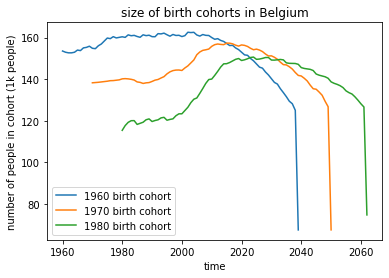

In [19]:
da_cohort_aligned.sel(country='Belgium', birth_year=1960).to_pandas().plot(label='1960 birth cohort')
da_cohort_aligned.sel(country='Belgium', birth_year=1970).to_pandas().plot(label='1970 birth cohort')
da_cohort_aligned.sel(country='Belgium', birth_year=1980).to_pandas().plot(label='1980 birth cohort')

plt.ylabel('number of people in cohort (1k people)')
plt.title('size of birth cohorts in Belgium')
plt.legend()

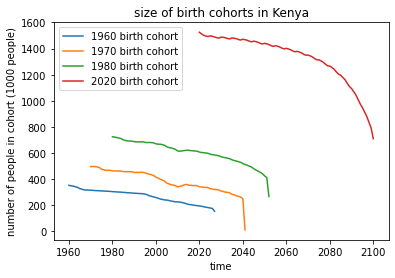

In [20]:
da_cohort_aligned.sel(country='Kenya', birth_year=1960).to_pandas().plot(label='1960 birth cohort')
da_cohort_aligned.sel(country='Kenya', birth_year=1970).to_pandas().plot(label='1970 birth cohort')
da_cohort_aligned.sel(country='Kenya', birth_year=1980).to_pandas().plot(label='1980 birth cohort')
da_cohort_aligned.sel(country='Kenya', birth_year=2020).to_pandas().plot(label='2020 birth cohort')

plt.ylabel('number of people in cohort (1000 people)')
plt.title('size of birth cohorts in Kenya')
plt.legend()

## 4. ds_cohort_align


Based on previous output calculates different things 
1. t_population: (=da_t) total population in country each year
2. population (=da_aligned/da_cohort_aligned) : tracking the birth cohort size each year, how many people of each birth cohort there are each year 
3. by_population_y0: size of 1960 cohort in 1960, size of 1961 cohort in 1961... (=da_by_p0)
4. by_population: sum of the people in a given cohort each year (i.e. how many people in 1960 b.c. in 1960 + in 1961 etc..) double counts over lifetime (=da_by) i.e. sum of the line in the plot above ("seize of birth cohorts in Belgium") - one number per birth cohort! 
7. t_weights: total population in country that year divided by total population in world that year 
6. by_y0_weights: same thing but just taking the cohort size in year 0 
5. by_weights: ratio between by_population of a certain birth cohort (i.e. sum of that cohort's size over every year), and the sum of that birth cohort's multi temporal sum over all countries - why are you doing this??

questions:
- is the 'ages' coord redundant? 



In [21]:
# create dataset out of birthyear aligned cohort sizes
def ds_cohort_align(
    da,
    da_aligned,
):
    """
    based on previous output calculates different things including total population, per cohort size... and weights 
    
    Inputs
        da (da): da_cohort_size, the number of people of each age alive each year from WCDE (av. 1950-2100)
        da_aligned (da): output of calc_birthyear_align # shall we just include that function inside this one? 

    Returns
        ds_cohort_sizes (ds) :  dataset with coords: country, birth_year, time, ages, different variables:
                                    1. t_population: (=da_t) total population in country each year
                                    2. population (=da_aligned/da_cohort_aligned) : tracking the birth cohort size each year, 
                                    how many people of each birth cohort there are each year 
                                    3. by_population_y0: size of 1960 cohort in 1960, size of 1961 cohort in 1961... (=da_by_p0)
                                    4. by_population: sum of the people in a given cohort each year (i.e. how many people in 1960 b.c. in 1960 + in 1961 etc..) 
                                    double counts over lifetime (=da_by) one number per birth cohort! 
                                    7. t_weights: total population in country that year divided by total population in world that year 
                                    6. by_y0_weights: same thing but just taking the cohort size in year 0 
                                    5. by_weights: ratio between by_population of a certain birth cohort (i.e. sum of that cohort's size over every year), 
                                    and the sum of that birth cohort's multi temporal sum over all countries
    
    """
    da_t = da.sum(dim='ages') # sum population in country over time (i.e. sum over all ages, get population each year in country)
    da_by = da_aligned.sum(dim='time') # sum population over birth years (with duplicate counting as we sum across birth cohorts lifespan) 
    # i.e. sum of the number of people in a given cohort each year 
    # population over birth years represented by first year of lifespan
    
    da_times=xr.DataArray(da_aligned.birth_year.data,dims='birth_year') # birth years 
    da_birth_years=xr.DataArray(da_aligned.birth_year.data,dims='birth_year') # birth years 
    da_by_y0 = da_aligned.sel(time=da_times,birth_year=da_birth_years) # select the cohort size in the year of birth (i.e. size of 1960 cohort in 1960 etc). 
    
    ds_cohort_sizes = xr.Dataset(
        data_vars={
            't_population': (da_t.dims,da_t.data), # population per timestep across countries for t_weights
            'population': (da_aligned.dims,da_aligned.data), # population per birth year distributed over time for emergence mask
            'by_population_y0': (da_by_y0.dims,da_by_y0.data), # size of each cohort in its y0 
            'by_population': (da_by.dims,da_by.data), # see above, da_by, for each birth year, get total number of people for by_weights (population in ds; duplicate counting risk with time sum)
        },
        coords={
            'country': ('country',da_aligned.country.data),
            'birth_year': ('birth_year',da_aligned.birth_year.data),
            'time': ('time',da_aligned.time.data),
            'ages': ('ages',da.ages.data)
        },
    )
    
    ds_cohort_sizes['t_weights'] = (ds_cohort_sizes['t_population'] / ds_cohort_sizes['t_population'].sum(dim='country')) # add cohort weights to dataset   
    ds_cohort_sizes['by_y0_weights'] = (ds_cohort_sizes['by_population_y0'] / ds_cohort_sizes['by_population_y0'].sum(dim='country')) # add cohort weights to dataset
    ds_cohort_sizes['by_weights'] = (ds_cohort_sizes['by_population'] / ds_cohort_sizes['by_population'].sum(dim='country')) # add cohort weights to dataset
    
    return ds_cohort_sizes


In [22]:

ds_cohorts = ds_cohort_align(
    da_cohort_size,
    da_cohort_aligned,
)

In [23]:
ds_cohorts.sel(country='Belgium')

<xarray.Dataset>
Dimensions:           (time: 154, birth_year: 141, ages: 105)
Coordinates:
    country           <U32 'Belgium'
  * birth_year        (birth_year) int64 1960 1961 1962 1963 ... 2098 2099 2100
  * time              (time) int64 1960 1961 1962 1963 ... 2110 2111 2112 2113
  * ages              (ages) int64 0 1 2 3 4 5 6 7 ... 98 99 100 101 102 103 104
Data variables:
    t_population      (time) float64 9.113e+03 9.176e+03 ... 1.479e+04 1.483e+04
    population        (birth_year, time) float64 153.5 153.0 ... 128.9 123.1
    by_population_y0  (birth_year) float64 153.5 154.6 155.7 ... 124.0 123.9
    by_population     (birth_year) float64 1.227e+04 1.238e+04 ... 1.77e+03
    t_weights         (time) float64 0.003028 0.002989 ... 0.001647 0.001656
    by_y0_weights     (birth_year) float64 0.001704 0.001674 ... 0.001517
    by_weights        (birth_year) float64 0.002222 0.002173 ... 0.001613

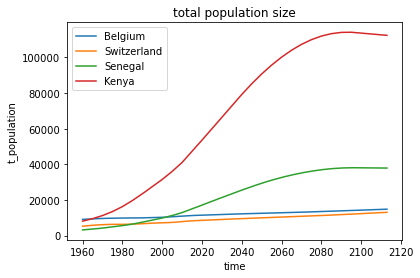

In [24]:
ds_cohorts['t_population'].sel(country='Belgium').plot(label='Belgium')
ds_cohorts['t_population'].sel(country='Switzerland').plot(label='Switzerland')
ds_cohorts['t_population'].sel(country='Senegal',).plot(label='Senegal')
ds_cohorts['t_population'].sel(country='Kenya').plot(label='Kenya')

plt.title('total population size')
plt.legend()

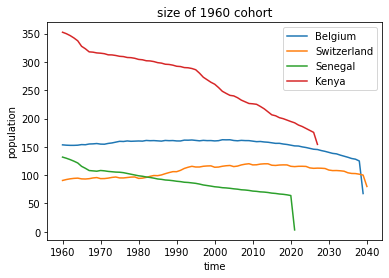

In [25]:
ds_cohorts['population'].sel(country='Belgium', birth_year=1960).plot(label='Belgium')
ds_cohorts['population'].sel(country='Switzerland', birth_year=1960).plot(label='Switzerland')
ds_cohorts['population'].sel(country='Senegal', birth_year=1960,).plot(label='Senegal')
ds_cohorts['population'].sel(country='Kenya', birth_year=1960).plot(label='Kenya')

plt.title('size of 1960 cohort')
plt.legend()

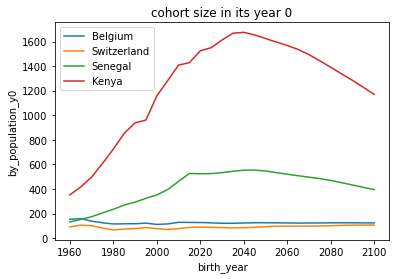

In [26]:
ds_cohorts['by_population_y0'].sel(country='Belgium').plot(label='Belgium')
ds_cohorts['by_population_y0'].sel(country='Switzerland').plot(label='Switzerland')
ds_cohorts['by_population_y0'].sel(country='Senegal').plot(label='Senegal')
ds_cohorts['by_population_y0'].sel(country='Kenya').plot(label='Kenya')

plt.title('cohort size in its year 0')
plt.legend()

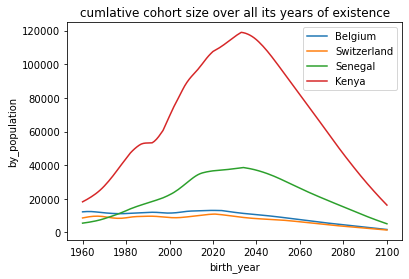

In [27]:
ds_cohorts['by_population'].sel(country='Belgium').plot(label='Belgium')
ds_cohorts['by_population'].sel(country='Switzerland').plot(label='Switzerland')
ds_cohorts['by_population'].sel(country='Senegal').plot(label='Senegal')
ds_cohorts['by_population'].sel(country='Kenya').plot(label='Kenya')

plt.title('cumlative cohort size over all its years of existence')
plt.legend()

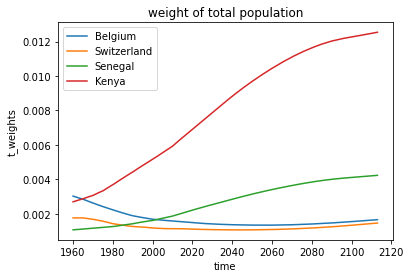

In [28]:
ds_cohorts['t_weights'].sel(country='Belgium').plot(label='Belgium')
ds_cohorts['t_weights'].sel(country='Switzerland').plot(label='Switzerland')
ds_cohorts['t_weights'].sel(country='Senegal').plot(label='Senegal')
ds_cohorts['t_weights'].sel(country='Kenya').plot(label='Kenya')

plt.title('weight of total population')
plt.legend()

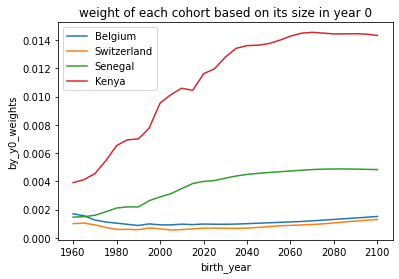

In [29]:
var='by_y0_weights'
ds_cohorts[var].sel(country='Belgium').plot(label='Belgium')
ds_cohorts[var].sel(country='Switzerland').plot(label='Switzerland')
ds_cohorts[var].sel(country='Senegal').plot(label='Senegal')
ds_cohorts[var].sel(country='Kenya').plot(label='Kenya')

plt.title('weight of each cohort based on its size in year 0')
plt.legend()

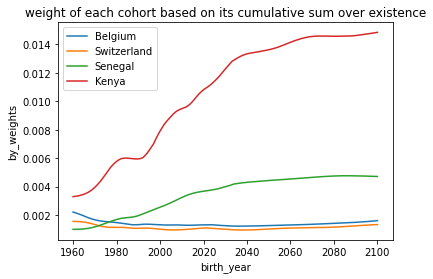

In [30]:
var='by_weights'
ds_cohorts[var].sel(country='Belgium').plot(label='Belgium')
ds_cohorts[var].sel(country='Switzerland').plot(label='Switzerland')
ds_cohorts[var].sel(country='Senegal').plot(label='Senegal')
ds_cohorts[var].sel(country='Kenya').plot(label='Kenya')

plt.title('weight of each cohort based on its cumulative sum over existence')
plt.legend()

# almost the same as weights_by_y0!

## 5. ds_exposure_align

MODIFICATION: NaNs are now treated as zeroes in the cumsum, as are zeros X) 

In [31]:
# create dataset out of birthyear aligned cohort exposure and regular rexposure, add cumulative exposure, 
def ds_exposure_align( # rename this !! 
    da,
):
        
    da_cumsum = da.cumsum(dim='time') #.where(da>0) # why are you doing where da >0 ??? 
    ds_exposure_cohort = xr.Dataset(
        data_vars={
            'exposure': (da.dims, da.data),
            'exposure_cumulative': (da_cumsum.dims, da_cumsum.data)
        },
        coords={
            'country': ('country', da.country.data),
            'birth_year': ('birth_year', da.birth_year.data),
            'time': ('time', da.time.data),
        },
    )
     
    return ds_exposure_cohort # rename this ?? call it cumsum or something ??

## 6. strj_emergence (extracts only!)

Part 1. on da_exposure_peryear_perage_percountry i.e. population-weighted average per country aligned and accumulated over lifetime

Part 2. on da_exposure_cohort i.e. population-weighted average AFA multiplied by cohort size, then accumulated over lifetime

TODO: 
- rename these and the inputs in these, look at other parts of strj_emnergence (e.g. calc_unprec_exposure and pop_frac_stats) to understand what these do and how to communicate results
- maybe make a function that does just this stuff before (the combination of the two functions?)


In [32]:
# Part 1. on da_exposure_peryear_perage_percountry i.e. population-weighted average per country aligned and accumulated over lifetime
# 

da_exposure_aligned = calc_birthyear_align(
                        da_exposure_peryear_perage_percountry,
                        df_life_expectancy_5,
                        by_emergence, # rename this !! 
                    )
# read through the AFA dataset diagonally based on birth year + life expectancy data 
                    
# dataset of birthyear aligned exposure, add cumulative exposure 
ds_exposure_aligned = ds_exposure_align(
    da_exposure_aligned,
)

In [33]:
# Part 2. on da_exposure_cohort i.e. population-weighted average AFA multiplied by cohort size, then accumulated over lifetime

# aligned cohort exposure age+time selections
da_exposure_cohort_aligned = calc_birthyear_align(
    da_exposure_cohort,
    df_life_expectancy_5,
    by_emergence,
)

# convert aligned cohort exposure to dataset - rename to cumsum ?? 
ds_exposure_cohort_aligned = ds_exposure_align(
    da_exposure_cohort_aligned,
)

Text(0, 0.5, 'n events')

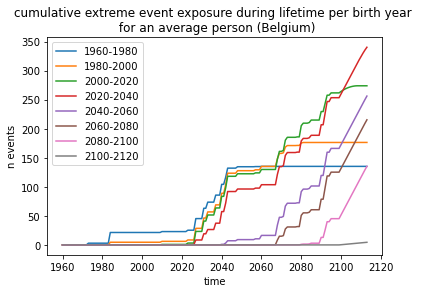

In [37]:
df = ds_exposure_aligned.sel(country='Belgium').exposure_cumulative.to_pandas().T
n = 20
df.groupby(np.arange(len(df.columns)) // n, axis=1).sum().plot() # group every 5 years together and calc sum and plot 
# Get the current legend
legend = plt.legend()
# Multiply the legend labels by 5
new_legend_labels = [f'{1960 + int(label.get_text()) * n}-{ 1960 + int(label.get_text()) * n + n}' for label in legend.get_texts()]
# Set the modified labels to the legend
for i, label in enumerate(legend.get_texts()):
    label.set_text(new_legend_labels[i])
    
plt.title('cumulative extreme event exposure during lifetime per birth year \n for an average person (Belgium)')
plt.ylabel('n events')

# this looks better ! why were you doing where da>0 ??? 
# pop-weighted average exposure per year accumulated over lifetime of an individual, cum sum
# should max number be the same as the output of calc_lifetime_exposure??? yes but that function was running only 1960 to 2020 birth cohorts (why ??)
# it increases then decreases ! incr > climate change, decr > lack of data 

#TODO: make this function script a utils.

Text(0.5, 1.0, 'max number of events during lifetime from cumsum \nproblem of death year > end of simulation \n(Belgium)')

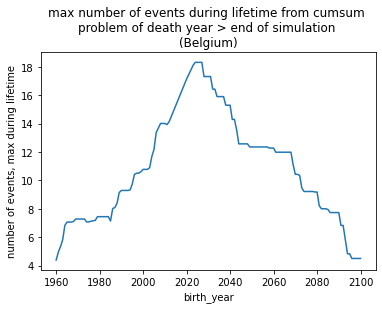

In [38]:
df.T.max(axis=1).plot()
plt.ylabel('number of events, max during lifetime')
plt.title('max number of events during lifetime from cumsum \nproblem of death year > end of simulation \n(Belgium)')

# decreases for later birth cohorts bc time only goes up to 2113 !! 
# so their lives are shorter than their life expectancy !! 
# what do we do about this? just not use anything with death later than 2113??
# this is a problem !! have to stop when the death year > end of simulation 

Text(0, 0.5, 'n events * n people (1k)')

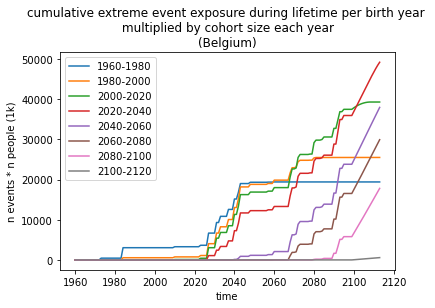

In [39]:
df = ds_exposure_cohort_aligned.sel(country='Belgium').exposure_cumulative.to_pandas().T
n = 20
df.groupby(np.arange(len(df.columns)) // n, axis=1).sum().plot() # group every 5 years together and calc sum and plot 
# Get the current legend
legend = plt.legend()
# Multiply the legend labels by 5
new_legend_labels = [f'{1960 + int(label.get_text()) * n}-{ 1960 + int(label.get_text()) * n + n}' for label in legend.get_texts()]
# Set the modified labels to the legend
for i, label in enumerate(legend.get_texts()):
    label.set_text(new_legend_labels[i])
    
plt.title('cumulative extreme event exposure during lifetime per birth year \n multiplied by cohort size each year \n(Belgium)')
plt.ylabel('n events * n people (1k)')

Text(0.5, 1.0, 'max number of events multiplied by cohort size each year \nproblem of death year > end of simulation \n(Belgium)')

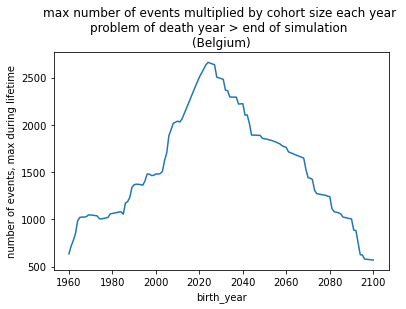

In [42]:
df.T.max(axis=1).plot()
plt.ylabel('number of events, max during lifetime')
plt.title('max number of events multiplied by cohort size each year \nproblem of death year > end of simulation \n(Belgium)')

# decreases for later birth cohorts bc time only goes up to 2113 !! 
# so their lives are shorter than their life expectancy !! 
# what do we do about this? just not use anything with death later than 2113??
# this is a problem !! have to stop when the death year > end of simulation 

# PART 2. Gridscale level 

--- TO DO ---- 